# Train a Vision Transformer on small datasets

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/07<br>
**Last modified:** 2022/01/10<br>
**Description:** Training a ViT from scratch on smaller datasets with shifted patch tokenization and locality self-attention.

In [1]:
!pip install -qq -U tensorflow-addons
!pip install matplotlib
!pip install tensorflow==2.8
!pip install keras==2.8
!pip install seaborn

## Setup

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

2023-01-09 13:43:52.608565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 13:43:52.608600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Prepare the data

In [2]:
base_train_dir = "dataset/Text-Classification/train_image"
base_test_dir = "dataset/Text-Classification/test_image"
train_label_path , test_label_path =  "dataset/Text-Classification/gt_train.txt" , "dataset/Text-Classification/gt_test.txt"

In [3]:
import pandas as pd

df_train = pd.read_csv( train_label_path , sep=';' , header=None , names = ['img_path','text'] )
df_train = df_train.dropna()
df_train = df_train.reset_index()

df_test = pd.read_csv( test_label_path , sep=';' , header=None , names = ['img_path','text'] )
df_test = df_test.dropna()
df_test = df_test.reset_index()

In [4]:
df_train.head()

,index,img_path,text
0,0,A_1.png,A
1,1,A_10.png,A
2,2,A_100.png,A
3,3,A_101.png,A
4,4,A_102.png,A


> dataframe preprocessing

In [5]:
from sklearn import preprocessing
import os

# label encoder
le = preprocessing.LabelEncoder()

# train label encoder
le.fit_transform( df_train.text )
# define the target dict
target_dict = { i_key : idx  for idx , i_key in enumerate(  le.classes_ ) }

def to_encode( label ):
    label_txt = str( label )
    return target_dict[ label_txt ]

def train_joinpath( path ):
  img_path = os.path.join( base_train_dir , path )
  return img_path

def test_joinpath( path ):
  img_path = os.path.join( base_test_dir , path )
  return img_path

df_train['label'] = df_train.text.apply( to_encode )
df_test['label'] = df_test.text.apply( to_encode )
df_train['img_path'] = df_train.img_path.apply( train_joinpath )
df_test['img_path'] = df_test.img_path.apply( test_joinpath )

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

> save the target label mapping

In [6]:
import joblib

joblib.dump(target_dict , "dataset/target_label.dict") 

['dataset/target_label.dict']

In [7]:
classes = le.classes_
print("Target Label  Classes :", classes)

Target Label  Classes : ['A' 'BA' 'CA' 'Caruk' 'DA' 'DYA' 'E' 'GA' 'HA' 'HYA' 'I' 'JA' 'K' 'KA'
 'KOMA' 'KSA' 'LA' 'LE' 'MA' 'N' 'NDA' 'NGA' 'NYA' 'NYCA' 'NYJA' 'O' 'PA'
 'PAMAEH' 'PAMEPET' 'PAMINGKAL' 'PANELENG' 'PANEULEUNG' 'PANGHULU'
 'PANGLAYAR' 'PANGWISAD' 'PANOLONG' 'PANYAKRA' 'PANYECEK' 'PANYUKU' 'PRA'
 'RA' 'RE' 'RO' 'RWA' 'RYA' 'SA' 'SYA' 'TA' 'TWA' 'TYA' 'U' 'WA' 'YA' 'eu'
 'kka' 'mba' 'mpa' 'nma' 'pasangan-wa']


> dataframe sample

In [8]:
df_train.head()

,index,img_path,text,label
0,3228,dataset/Text-Classification/train_image/PANYEC...,PANYECEK,37
1,2816,dataset/Text-Classification/train_image/PANGLA...,PANGLAYAR,33
2,1532,dataset/Text-Classification/train_image/LA_76.png,LA,16
3,414,dataset/Text-Classification/train_image/DA_114...,DA,4
4,4317,dataset/Text-Classification/train_image/WA_3.png,WA,51


> sample visualization

/tmp/ipykernel_2451/4183374882.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_rgb = np.array(Image.open( df_train.iloc[100].img_path ).resize( (72,72) , PIL.Image.BICUBIC  ))


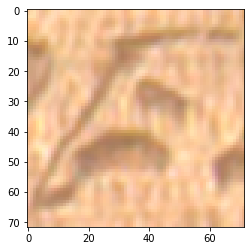

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import PIL

img_rgb = np.array(Image.open( df_train.iloc[100].img_path ).resize( (72,72) , PIL.Image.BICUBIC  ))
plt.imshow( img_rgb )

## Prepare Dataset

In [10]:
def prepare_dateset( df ):
    img_set , target_set = [] ,[]
    for i_img_path , i_label in zip( df.img_path.values , df.label.values ):
        
        # read the rgb image
        img_rgb = np.array(Image.open( i_img_path ).resize( ( 128 , 128 ) , PIL.Image.BICUBIC  )  )
        # add the image into the placeholder
        img_set.append(  img_rgb )
        target_set.append( tf.keras.utils.to_categorical( i_label , num_classes = len(classes ) ) )
    
    return np.array( img_set  ).astype(np.float32) , np.array( target_set ) 

In [11]:
NUM_CLASSES = len( target_dict )

(x_train, y_train) = prepare_dateset( df_train )
(x_test, y_test) = prepare_dateset( df_test )

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

/tmp/ipykernel_2451/3570793979.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_rgb = np.array(Image.open( i_img_path ).resize( ( 128 , 128 ) , PIL.Image.BICUBIC  )  )


x_train shape: (4397, 128, 128, 3) - y_train shape: (4397, 59)
x_test shape: (2718, 128, 128, 3) - y_test shape: (2718, 59)


## Configure the hyperparameters

The hyperparameters are different from the paper. Feel free to tune
the hyperparameters yourself.

In [12]:
# AUGMENTATION
image_size = 128
input_shape = (128,128,3)

# hyper parameters
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 200
patch_size = 16  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 256
dim_coefficient = 4
num_heads = 8
attention_dropout = 0.3
projection_dropout = 0.3
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 16 X 16 = 256 
Patches per image: 64


## Use data augmentation

A snippet from the paper:

*"According to DeiT, various techniques are required to effectively
train ViTs. Thus, we applied data augmentations such as CutMix, Mixup,
Auto Augment, Repeated Augment to all models."*

In this example, we will focus solely on the novelty of the approach
and not on reproducing the paper results. For this reason, we
don't use the mentioned data augmentation schemes. Please feel
free to add to or remove from the augmentation pipeline.

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing( image_size , image_size ),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-01-09 13:45:31.182493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-09 13:45:31.182531: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 13:45:31.182559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-01-09 13:45:31.182801: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 13:45:31.189362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 864485376 e

## Implement the patch extraction and encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [14]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

## Implement the external attention block

In [15]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

## Implement the MLP

In [16]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

## Implement the Transformer block

In [17]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x


## Implement the EANet model

In [18]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense( len(classes) , activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

### model training

In [ ]:
total_steps = int((len(x_train) / batch_size ) * num_epochs )
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)


scheduled_lrs = WarmUpCosine(
        learning_rate_base= learning_rate ,
        total_steps=total_steps,
        warmup_learning_rate=0.001 ,
        warmup_steps=warmup_steps,
)



# define callbacks for learning rate schedular and weight saving
checkpoint_filepath = "eanet_classification.h5"
callbacks = [
        tf.keras.callbacks.LearningRateScheduler( scheduled_lrs ) ,
        tf.keras.callbacks.ModelCheckpoint(
                                        filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)
]



model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ]
)


history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
    callbacks=  callbacks
)

_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size= batch_size )
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/200


2023-01-09 13:45:40.310420: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 691470336 exceeds 10% of free system memory.


28/28 [==============================] - 53s 2s/step - loss: 4.1598 - accuracy: 0.0355 - top-5-accuracy: 0.1692 - val_loss: 3.9456 - val_accuracy: 0.0364 - val_top-5-accuracy: 0.1682 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - 40s 1s/step - loss: 3.8501 - accuracy: 0.0560 - top-5-accuracy: 0.2167 - val_loss: 3.7785 - val_accuracy: 0.0852 - val_top-5-accuracy: 0.2568 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 40s 1s/step - loss: 3.7502 - accuracy: 0.0631 - top-5-accuracy: 0.2519 - val_loss: 3.6866 - val_accuracy: 0.0682 - val_top-5-accuracy: 0.2614 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 40s 1s/step - loss: 3.6876 - accuracy: 0.0779 - top-5-accuracy: 0.2903 - val_loss: 3.6470 - val_accuracy: 0.0841 - val_top-5-accuracy: 0.3148 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 40s 1s/step - loss: 3.6244 - accuracy: 0.0967 - top-5-accuracy: 0.3307 - val_loss: 3.5090 - val_accuracy: 0.0841 - val_top-5-ac

2023-01-09 15:58:14.527165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 534380544 exceeds 10% of free system memory.


22/22 [==============================] - 8s 354ms/step - loss: 1.5915 - accuracy: 0.7675 - top-5-accuracy: 0.9500
Test accuracy: 76.75%
Test top 5 accuracy: 95.0%


# print prediction stats

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report

def print_info( preds , targets  ):
    class_dict= target_dict 
    labels= targets

    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}

    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    
    df_list = []
    
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index= labels[i][0]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred

            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            
        y_pred.append(pred_index)    
        
        i_sample ={
            "prediction": new_dict[ pred_index ] ,
            "gt" : new_dict[ true_index ]
        }
        
        df_list.append( i_sample )

    if len(classes)<= 80:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes , zero_division=0)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)
        
    # generate the prediction dataframe
    df_ = pd.DataFrame( df_list )
    df_.to_csv("predictions.csv")

> geenerate predictions and stats

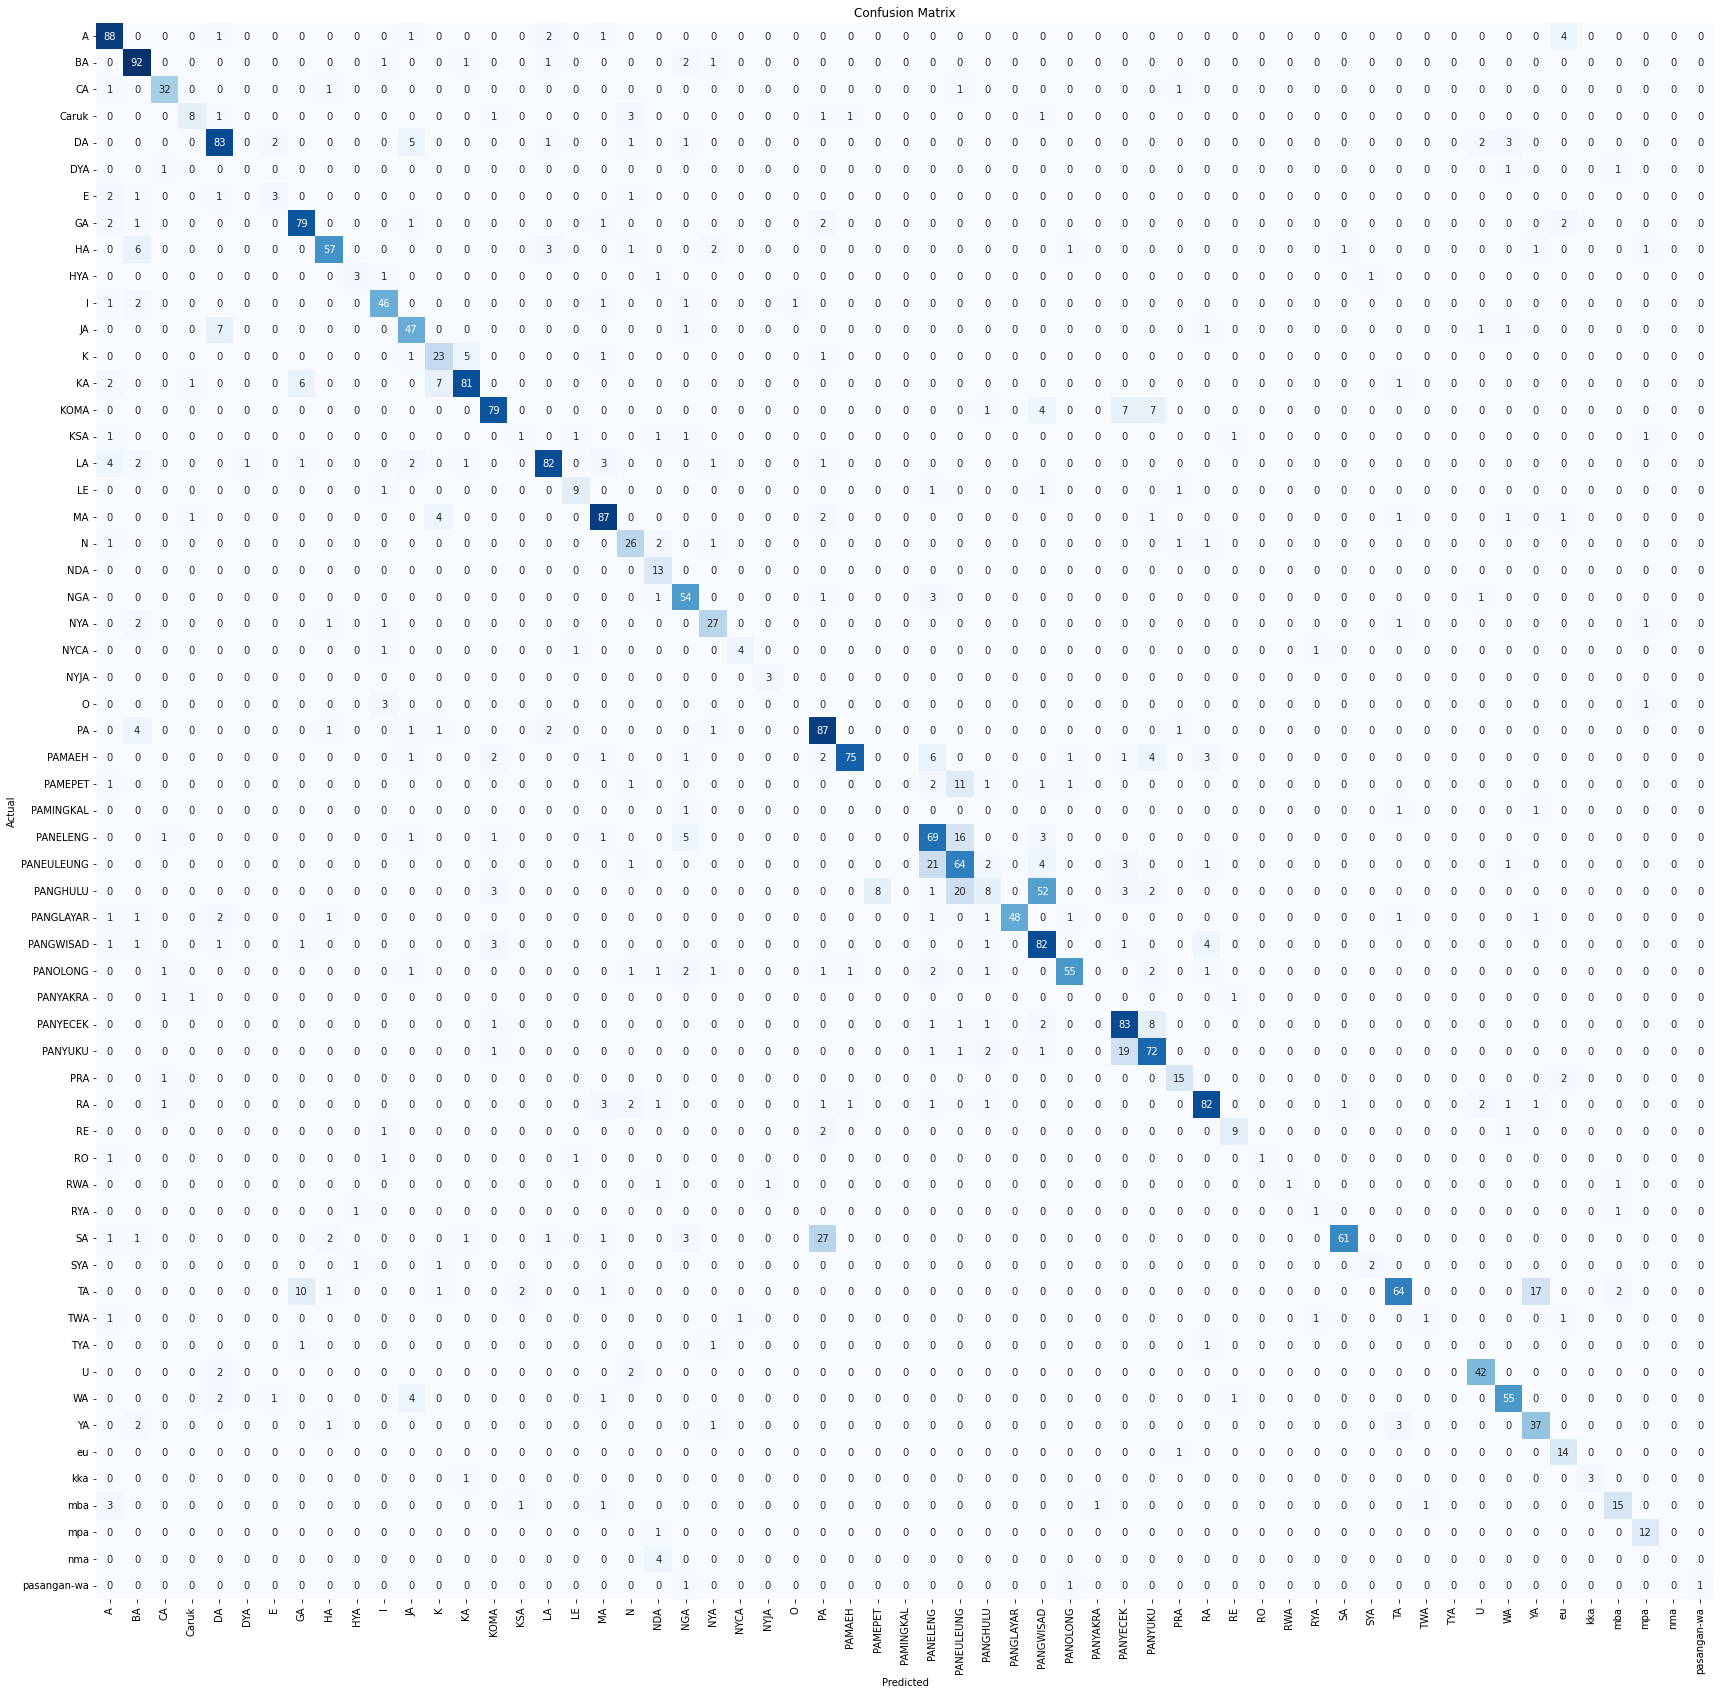

Classification Report:
----------------------
               precision    recall  f1-score   support

           A       0.79      0.91      0.85        97
          BA       0.80      0.94      0.86        98
          CA       0.84      0.89      0.86        36
       Caruk       0.73      0.50      0.59        16
          DA       0.83      0.85      0.84        98
         DYA       0.00      0.00      0.00         3
           E       0.50      0.38      0.43         8
          GA       0.81      0.90      0.85        88
          HA       0.88      0.78      0.83        73
         HYA       0.60      0.50      0.55         6
           I       0.82      0.88      0.85        52
          JA       0.72      0.81      0.76        58
           K       0.62      0.74      0.68        31
          KA       0.90      0.83      0.86        98
        KOMA       0.87      0.81      0.84        98
         KSA       0.25      0.14      0.18         7
          LA       0.89      0.84 

In [29]:
preds= model.predict( x_test ) 
print_info( preds , np.argmax(y_test, axis=-1).reshape(-1,1) ) 